# COMP90072 Project: Abelian Sand-pile Model 

## Imports and Defining Utility Functions

In [1]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.figure import Figure
from matplotlib.axes import Axes

import sow

# Some initialisations and type hints.
np.random.seed(90072)
fig: Figure
ax: Axes | list[Axes]

## The Grid Model

### Toppling Check

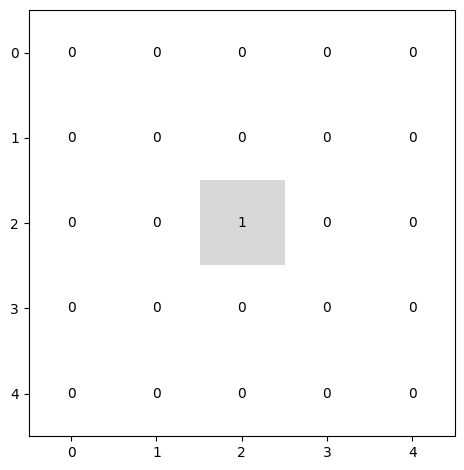

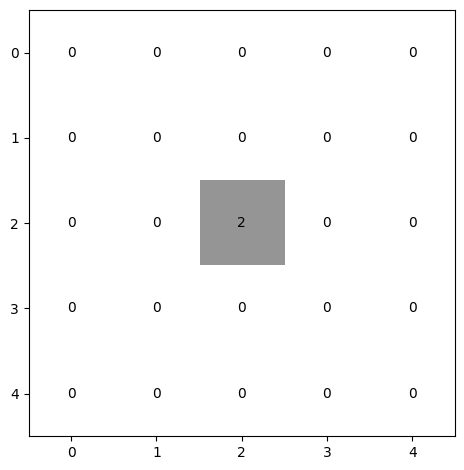

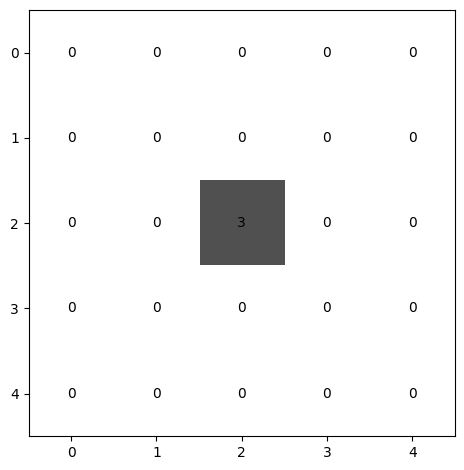

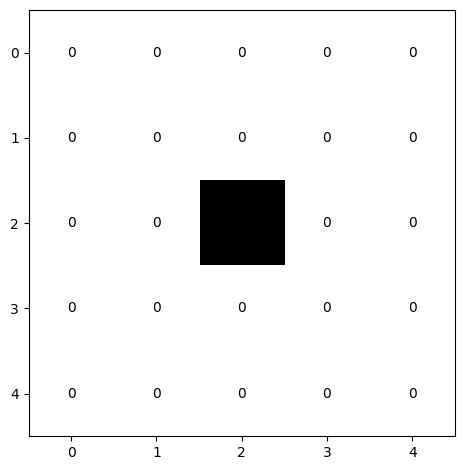

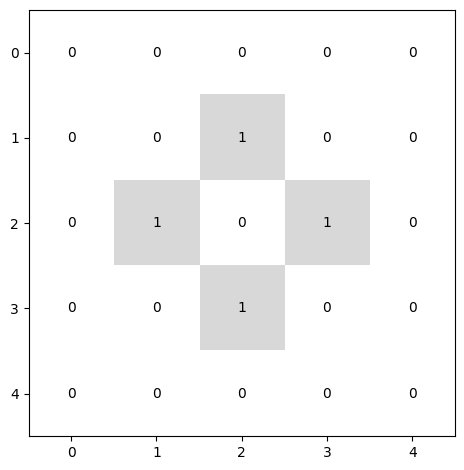

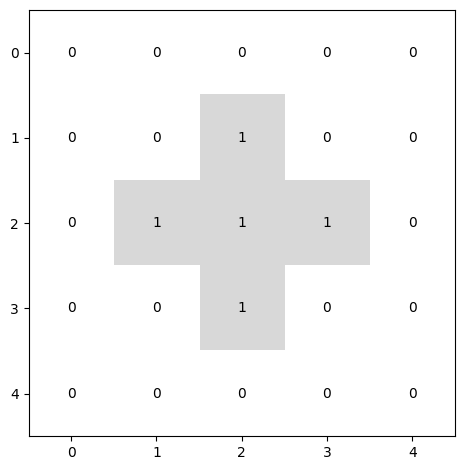

In [2]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(5, 5)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# We drop at sand at the same spot to check the model. Notice that the middle 
# point is floor of half the vertex count, by design.
model.manager = sow.ConstantDropper(graph.vcount() // 2)

def grid_visualiser(context: sow.SimulationContext):
    """ Creates a custom grid visualiser.
    
    :param context: The simulation context.
    :return: Figure and axes object generated by matplotlib.
    """
    return sow.visualise_grid(
        5, 5, context.model.height, max_height=context.model.topple_limit, 
        xticks="auto", yticks="auto", labels="auto")

# Create the listeners. 
image_maker = sow.ImageMaker(visualiser=grid_visualiser)
video_maker = sow.MovieMaker(max_frame=model.t_lim)

model.add_listener([
    image_maker
])

# Run the simulation.
_ = model.simulate(6)

# View the images.
for x in image_maker.images[:5]:
    x[0].show()


### Pattern at Scale

In [3]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(99, 99)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# We drop at sand at the same spot to check the model. Notice that the middle 
# point is floor of half the vertex count, by design.
model.manager = sow.ConstantDropper(graph.vcount() // 2)

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(10_000_000)

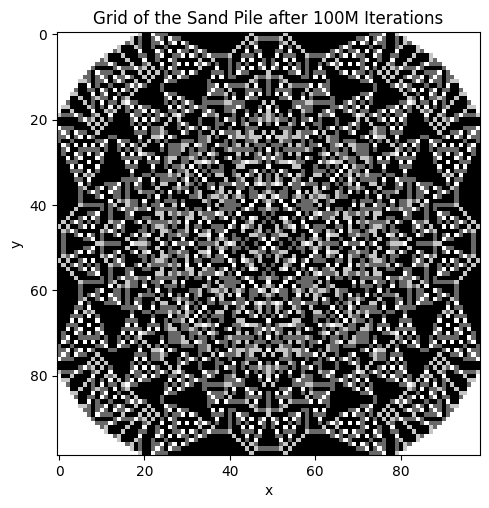

In [4]:
fig, ax = plt.subplots()
_, _ = model.visualise_grid(99, 99, fig=fig, ax=ax)
ax.set_title("Grid of the Sand Pile after 100M Iterations")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.show()
fig.savefig("out/grid.jpg")

### Mean Height Investigation

The mean value is 2.0541
The sample variance is 0.0004


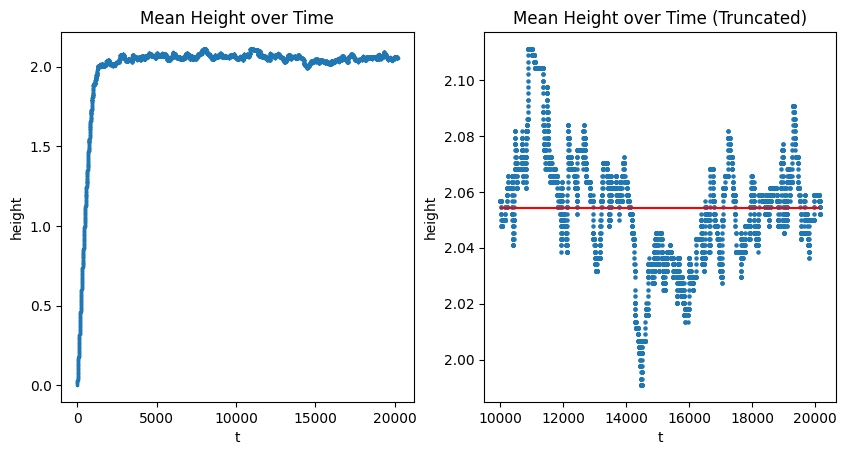

In [5]:
def mean_height_investigation(model, model_name):
    """ A helper function to investigate mean height. """
    # Add the mean collector listener.
    mean_collector = sow.StatisticsCollector(sow.ContextTransformer.mean_height)
    model.add_listener([mean_collector])
    
    # Conduct the simulation.
    model.simulate(20_000)
    mean_height = mean_collector.value_history
    
    # Initialise the plots.
    fig, ax = plt.subplots(ncols=2)
    
    # Plots the result as a graph.
    ax[0].scatter(np.arange(0, len(mean_height)), mean_height, s=2)
    ax[0].set_title("Mean Height over Time")
    ax[0].set_xlabel("t")
    ax[0].set_ylabel("height")
    
    # Let us focus on the flat tail.
    ax[1].scatter(np.arange(0, len(mean_height))[10_000:], mean_height[10_000:], 
                  s=5)
    ax[1].hlines(np.mean(mean_height[10_000:]), 10_000, len(mean_height), 
                 color="r")
    ax[1].set_title("Mean Height over Time (Truncated)")
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("height")
    
    # Display the figure
    fig.set_figwidth(10)
    fig.show()
    fig.savefig(f"out/{model_name}_mean_height.jpg")
    
    # Prints the mean and variance of the truncated plot.
    print(f"The mean value is {np.mean(mean_height[10_000:]):.4f}")
    print(f"The sample variance is {np.var(mean_height[10_000:]):.4f}")

# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(21, 21)
model = sow.Model(graph=graph, boundary_vertices=boundary)
mean_height_investigation(model, "grid")

### Avalanche Statistics

In [6]:
def compute_avalanche_statistics(model):
    """ A helper function to compute avalanche statistics. """
    # Add the mean collector listener.
    topple_occurrence_collector = sow.StatisticsCollector(
        sow.ContextTransformer.topple_occurrence
    )
    loss_collector = sow.StatisticsCollector(
        sow.ContextTransformer.sand_loss
    )
    drop_location_collector = sow.StatisticsCollector(
        sow.ContextTransformer.drop_location
    )
    model.add_listener([
        topple_occurrence_collector, loss_collector, drop_location_collector
    ])
    
    # No more listeners since they will slow it down. We are only interested in the 
    # final image anyway, at this stage.
    model.simulate(1_000_000)
    return sow.avalanche_statistics(
        topple_occurrence_collector.value_history, 
        loss_collector.value_history, 
        drop_location_collector.value_history
    )

# Make a grid graph and create the model.
model = sow.Model(graph=graph, boundary_vertices=boundary)
duration, loss, area = compute_avalanche_statistics(model)

#### Avalanche Sand Loss Distribution and Area Distribution

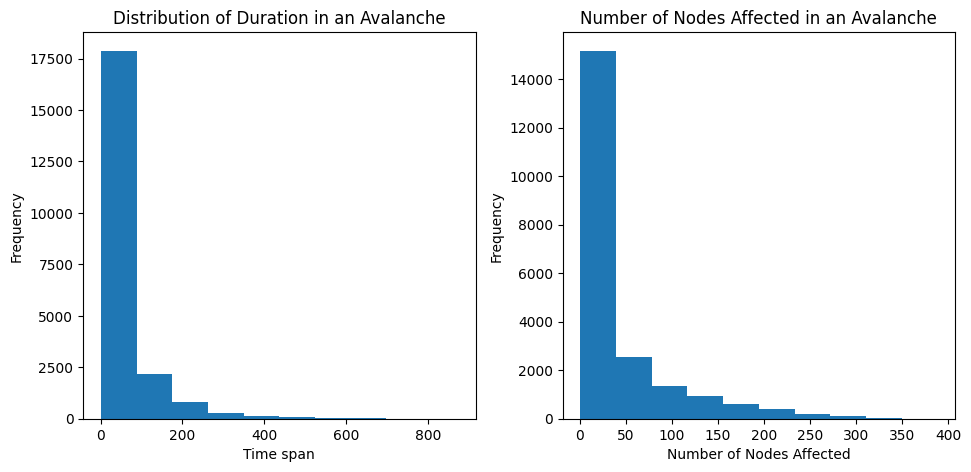

In [7]:
def duration_area_juxtaposition(duration, area, name):
    """ A helper function to plot duration and area histograms. """
    fig, ax = plt.subplots(ncols=2)
    
    # Plots the avalanche sand loss.
    ax[0].hist(duration)
    ax[0].set_title("Distribution of Duration in an Avalanche")
    ax[0].set_xlabel("Time span")
    ax[0].set_ylabel("Frequency")
    
    # Plots the area covered by an avalanche.
    ax[1].hist(area)
    ax[1].set_title("Number of Nodes Affected in an Avalanche")
    ax[1].set_xlabel("Number of Nodes Affected")
    ax[1].set_ylabel("Frequency")
    
    # Display and save the figure.
    fig.set_figwidth(9.8)
    fig.show()
    fig.tight_layout(pad=1)
    fig.savefig(f"out/{name}_avalanche.jpg")

duration_area_juxtaposition(duration, area, "grid")

#### Fitting the Distributions and Truncating the Tails

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     2969.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          3.58e-208
Time:                        22:56:29   Log-Likelihood:                 579.62
No. Observations:                 484   AIC:                            -1155.
Df Residuals:                     482   BIC:                            -1147.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0487      0.018    -59.646      0.0

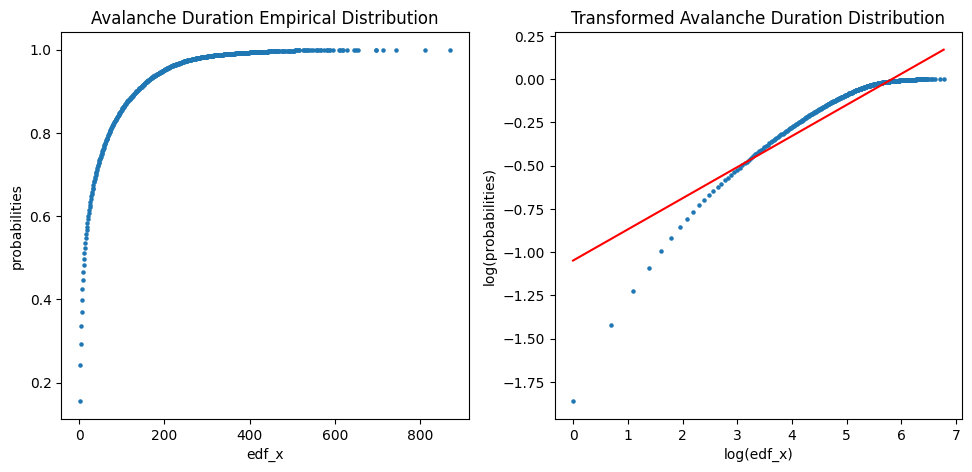

In [8]:
def edf_transform(realisations: list[float]):
    """ Computes the empirical distribution function from observations.

    :param realisations: i.i.d. observations of an arbitrary distribution.
    :return: The empirical distribution function given by x and y values.
    """
    counts = Counter(realisations)
    pmf = sorted([(x, y / sum(counts.values())) for x, y in counts.items()])
    edf_x, pmf_y = zip(*pmf)
    edf_y = np.cumsum(pmf_y)
    return np.array(edf_x), edf_y

def fit_heavy_tail(realisations: list[int | float], model_name: str, 
                   stat_name: str):
    """ A helper function for fitting a heavy-tail distribution. """
    # Compute the original empirical distribution function.
    fig, ax = plt.subplots(ncols=2)
    edf_x, edf_y = edf_transform(realisations)
    
    # Make a plot of the distribution.
    ax[0].scatter(edf_x, edf_y, s=5)
    ax[0].set_title(f"Avalanche {stat_name.title()} Empirical Distribution")
    ax[0].set_xlabel("edf_x")
    ax[0].set_ylabel("probabilities")

    # Fitting the tail of the distribution. 
    # For robustness, we fit the empirical distribution function.
    edf_x_fit = np.log(edf_x)
    edf_y_fit = np.log(edf_y)
    
    # Fit the linear model using ordinary least squares.
    # Yep, I know this is weird, but the right order as per the package doc.
    stats_model = sm.OLS(edf_y_fit, sm.add_constant(edf_x_fit))
    result = stats_model.fit()
    print(result.summary())

    # Make a plot of the fit.
    ax[1].scatter(edf_x_fit, edf_y_fit, s=5)
    ax[1].plot(edf_x_fit, result.fittedvalues, color="r", linestyle="-", 
               linewidth=1.5)
    ax[1].set_title(f"Transformed Avalanche {stat_name.title()} Distribution")
    ax[1].set_xlabel("log(edf_x)")
    ax[1].set_ylabel("log(probabilities)")
    
    # Display the result.
    fig.set_figwidth(9.8)
    fig.tight_layout(pad=1)
    fig.show()
    fig.savefig(f"out/{model_name}_avalanche_{stat_name}.jpg")

fit_heavy_tail(duration, "grid", "duration")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     3814.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          2.24e-183
Time:                        22:56:29   Log-Likelihood:                 445.92
No. Observations:                 332   AIC:                            -887.8
Df Residuals:                     330   BIC:                            -880.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2073      0.018    -68.502      0.0

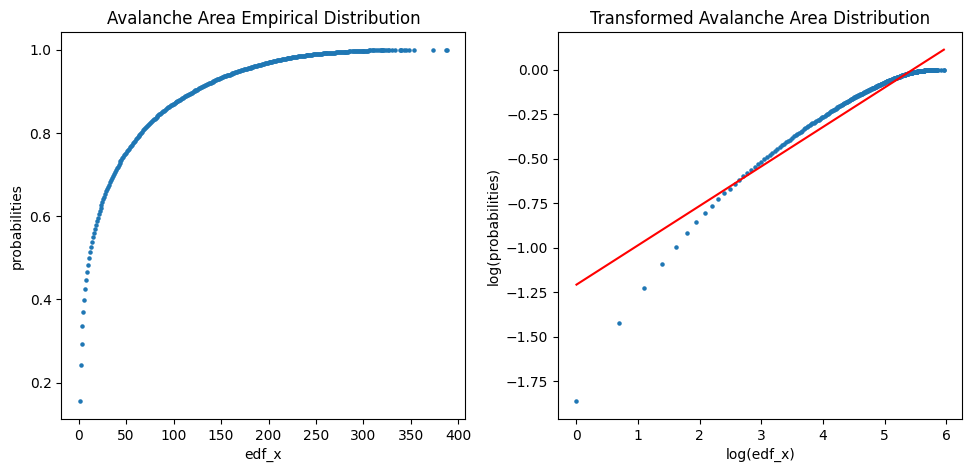

In [9]:
fit_heavy_tail(area, "grid", "area")

## The Tree

### Pattern at Scale

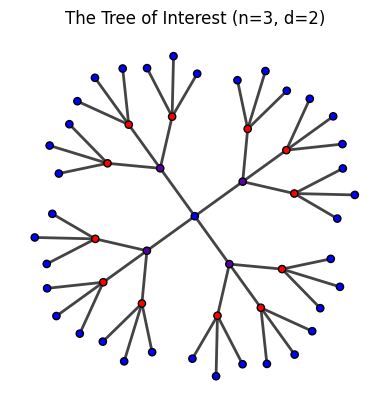

In [10]:
# Make a graph and create a visualisation.
graph, boundary = sow.make_interesting_tree(3, 2)
model = sow.Model(graph=graph, boundary_vertices=boundary)
model.manager = sow.ConstantDropper(0)
model.simulate(63)
fig, ax = model.visualise_graph()

# Display and save the figure.
ax.set_title("The Tree of Interest (n=3, d=2)")
fig.show()
fig.savefig("out/tree.jpg")

### Mean Height

The mean value is 1.7328
The sample variance is 0.0014


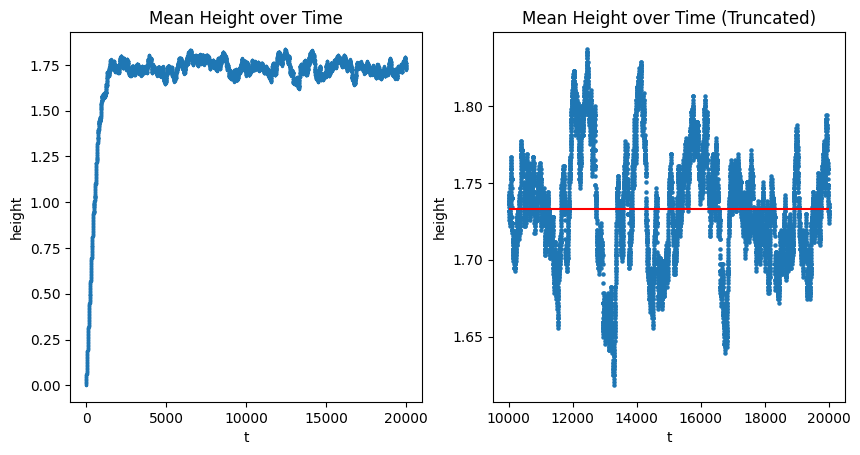

In [11]:
graph, boundary = sow.make_interesting_tree(3, 4)
model = sow.Model(graph=graph, boundary_vertices=boundary)
mean_height_investigation(model, "tree")

### Avalanche Statistics

In [12]:
# Make a grid graph and create the model.
model = sow.Model(graph=graph, boundary_vertices=boundary)
duration, _, area = compute_avalanche_statistics(model)

#### Duration and Area

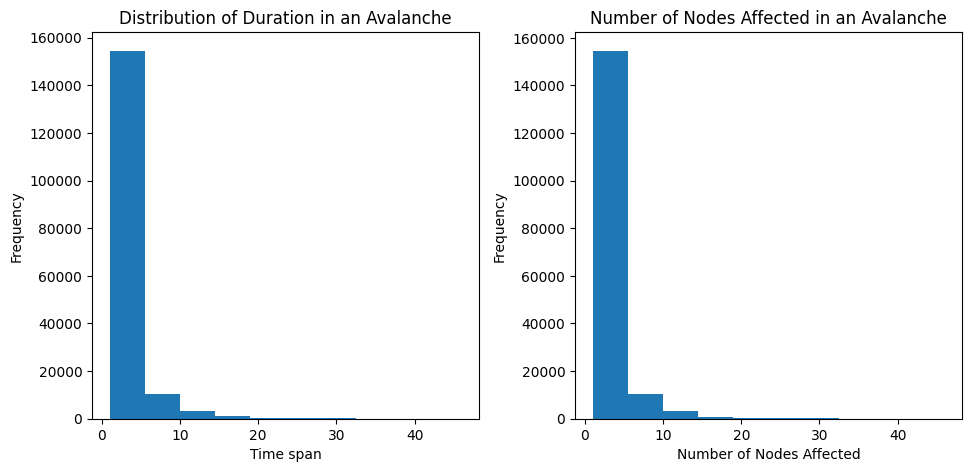

In [13]:
duration_area_juxtaposition(duration, area, "tree")

#### Duration Empirical Distribution

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     75.70
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           1.13e-10
Time:                        22:56:36   Log-Likelihood:                 51.542
No. Observations:                  41   AIC:                            -99.08
Df Residuals:                      39   BIC:                            -95.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3502      0.037     -9.472      0.0

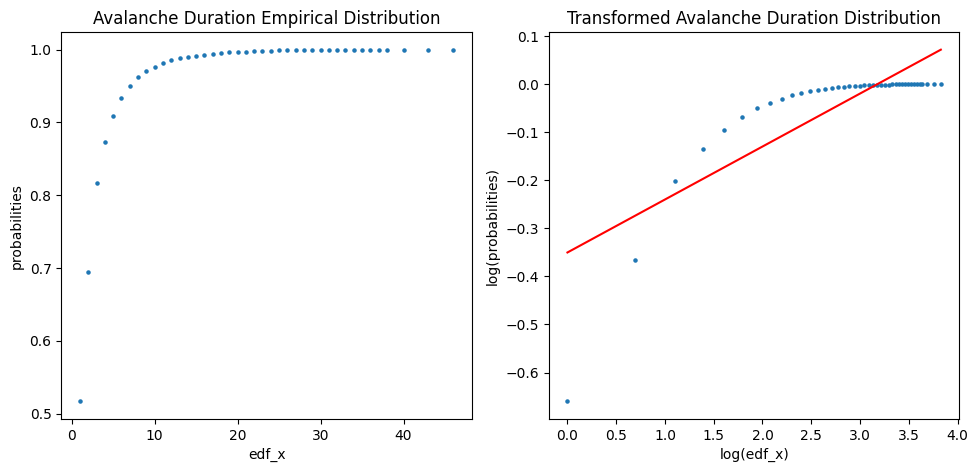

In [14]:
fit_heavy_tail(duration, "tree", "duration")

#### Area Empirical Distribution

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     74.60
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           1.37e-10
Time:                        22:56:36   Log-Likelihood:                 51.343
No. Observations:                  41   AIC:                            -98.69
Df Residuals:                      39   BIC:                            -95.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3486      0.037     -9.404      0.0

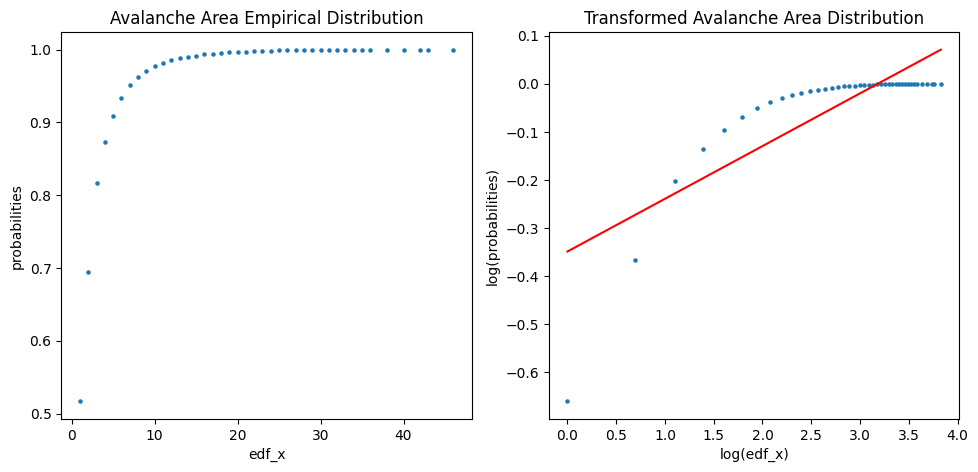

In [15]:
fit_heavy_tail(area, "tree", "area")

## The Punctured Donut Graph

The mean value is 2.1177
The sample variance is 0.0001


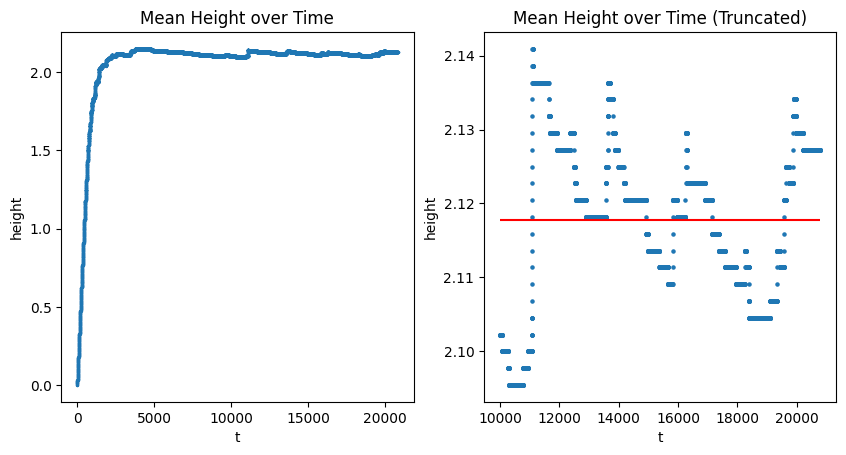

In [16]:
# Make a graph and create the model.
graph, boundary = sow.make_punctured_donut_graph(21, 21)
model = sow.Model(graph=graph, boundary_vertices=boundary)
mean_height_investigation(model, "donut")

### Avalanche Statistics

In [17]:
# Make a grid graph and create the model.
model = sow.Model(graph=graph, boundary_vertices=boundary)
duration, _, area = compute_avalanche_statistics(model)

#### Duration and Area

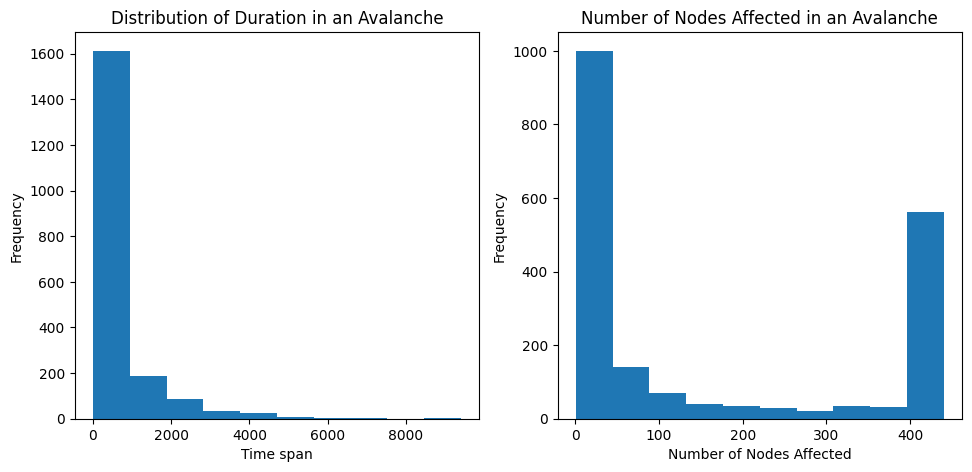

In [18]:
duration_area_juxtaposition(duration, area, "donut")

#### Duration Empirical Distribution

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 1.920e+04
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:56:41   Log-Likelihood:                 1257.4
No. Observations:                 769   AIC:                            -2511.
Df Residuals:                     767   BIC:                            -2502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3396      0.008   -172.284      0.0

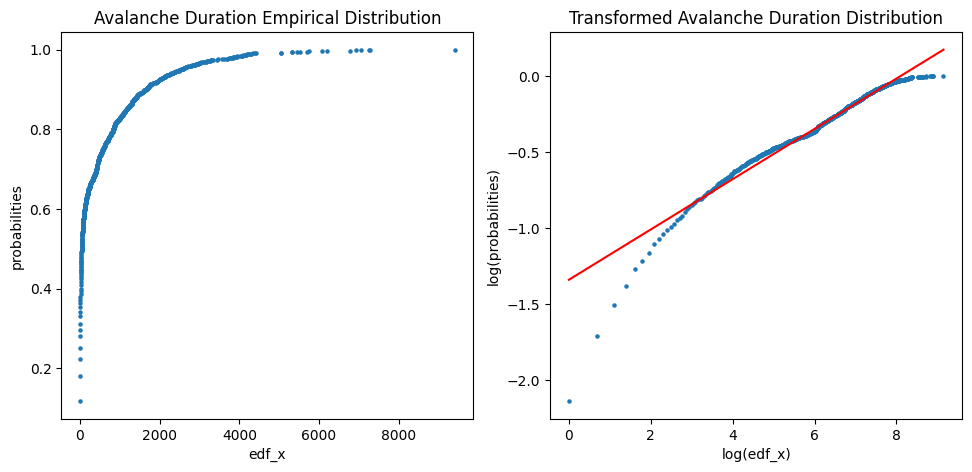

In [19]:
fit_heavy_tail(duration, "donut", "duration")

#### Area Empirical Distribution

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     3554.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          3.23e-166
Time:                        22:56:42   Log-Likelihood:                 399.09
No. Observations:                 296   AIC:                            -794.2
Df Residuals:                     294   BIC:                            -786.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4778      0.017    -88.634      0.0

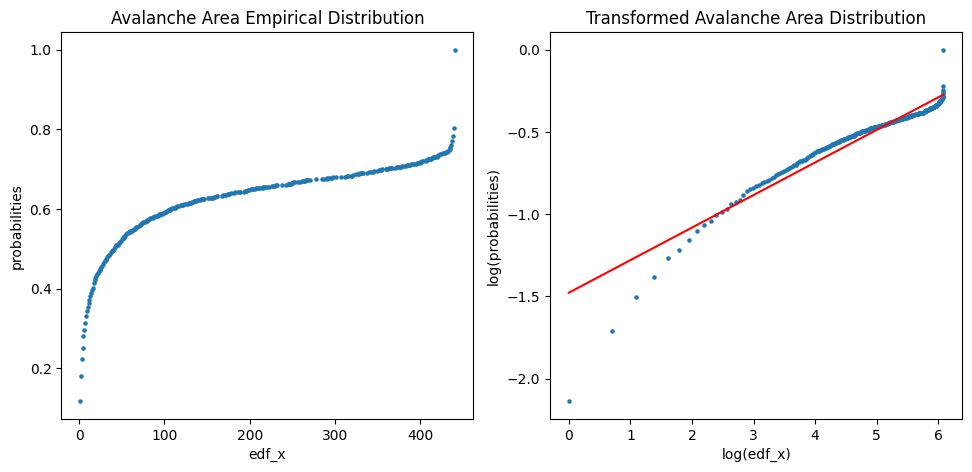

In [20]:
fit_heavy_tail(area, "donut", "area")

 ## Other Investigations

#### Avalanche Sand Lost

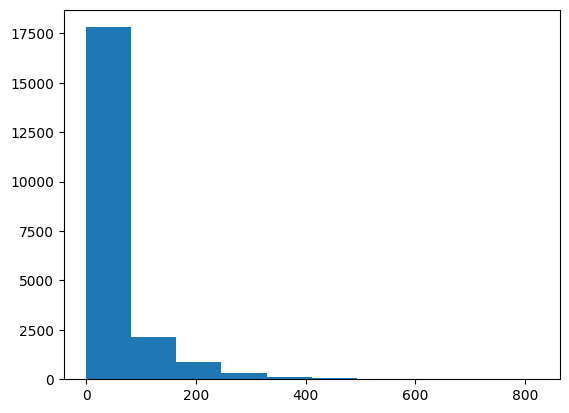

In [21]:
plt.hist(loss)
plt.show()